# The `algorithms` Package

As the name says, this package brings some algorithmic functionalities that you might need and that you cannot find in other packages.

Let's start by importing it and initialising a Brain:

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

from maybrain import utils
from maybrain import resources as rr
from maybrain import brain as mbt
from maybrain import algorithms as mba
from maybrain import constants as ct
from maybrain.plotting import histograms as hh

a = mbt.Brain()
a.import_adj_file(rr.DUMMY_ADJ_FILE_500)
a.import_spatial_info(rr.MNI_SPACE_COORDINATES_500)

## Normalisation

If you want to normalise the measures of a certain brain over other (random) graphs, you can use `algorithms.normalisation` module.

### Generating random graphs

There are many ways to generate random graphs. One way, is to generate random graphs based on the degree sequence. This might be useful to dissociate metrics from variations in degree. When you pass a brain to `generate_random_graph_from_degree()` it will generate a random `nx.Graph` with the same degree sequence. 

Due to the nature of the underlying random algorithm for graph generation, sometimes the random graph can have a *slightly* different degree sequence. If you want to have a random graph with exactly the same degree sequence as the original, just set the parameter `throw_exception` to True. By doing so, everytime the random graph doesn't have exaclty the same degree sequence, it will throw an Exception, and you can run the algorithm again. 

In [2]:
# Thresholding original brain
a.apply_threshold(threshold_type="edgePC", value=1)

# Getting the random graph
while True:
    try:
        rand = mba.generate_random_graph_from_degree(a, throw_exception=True)
        break # if it reaches here, means randomiser didn't throw any exception, so break while
    except mba.RandomGenerationError as error:
        print("Degree sequence not the same, running again the graph generator...")
        pass

As you can see from the following outputs, the degree sequence in the random graph is the same as the degree sequence of the original brain's graph:

[(0, 5), (1, 13), (2, 2), (3, 7), (4, 0), (5, 6), (6, 1), (7, 2), (8, 0), (9, 3)]
[(0, 5), (1, 13), (2, 2), (3, 7), (4, 0), (5, 6), (6, 1), (7, 2), (8, 0), (9, 3)]


(array([ 187.,  109.,   91.,   32.,   26.,   25.,   12.,   11.,    4.,    3.]),
 array([  0. ,   2.4,   4.8,   7.2,   9.6,  12. ,  14.4,  16.8,  19.2,
         21.6,  24. ]),
 <a list of 10 Patch objects>)

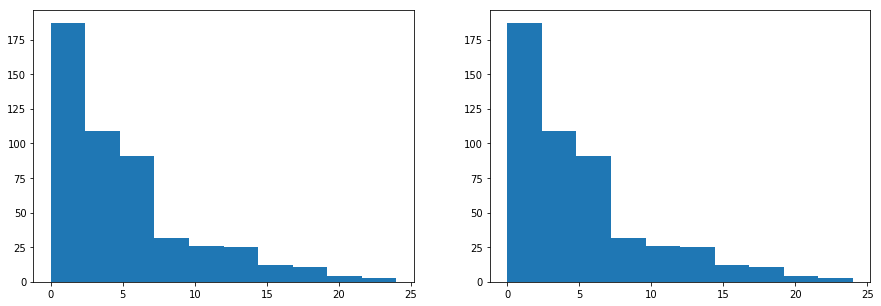

In [3]:
# Printing the 10 first nodes and respective degree of the original and random graphs
print(list(nx.degree(a.G))[0:10])
print(list(nx.degree(rand))[0:10])

# Plotting degree distribution
fig, axarr = plt.subplots(1,2, figsize=(15, 5))
axarr[0].hist(dict(nx.degree(a.G)).values())
axarr[1].hist(dict(nx.degree(rand)).values())


The original brain might have several attributes on the nodes and the edges, and in case you need to have those attributes in the random graph, you can set the arguments `node_attrs` and `edge_attrs` to say which attributes you need to have in the random graph. With regards to the node's attributes, the mapping from the original to the random is direct. However, it's impossible to define a specific mapping from the original edges to the edges in the random graphs.

The following code shows the graph generation by maintaining the weights of the edges. You can see that although the weight distribution is maintained, it is impossible for the nodes in the random graphs to have exactly the same weights as before. Nevertheless, you can see that the generation algorithm shuffles the weights in order to make those values similar.

[(0, 4.2659873452830182), (1, 10.98963629264151), (2, 1.5103898528301887), (3, 5.7168956214905657), (4, 0)]
[(0, 4.4859360728301887), (1, 11.278084690943396), (2, 1.5103898528301887), (3, 6.3366183243396215), (4, 0)]


(<matplotlib.figure.Figure at 0x7fe39bbf89b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe39be3b518>)

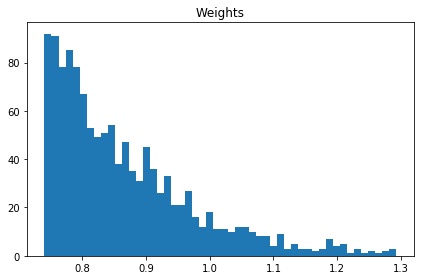

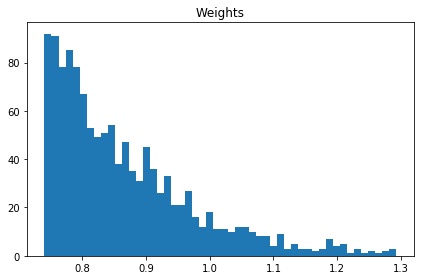

In [4]:
# Getting the random graph again
while True:
    try:
        rand = mba.generate_random_graph_from_degree(a, throw_exception=True, edge_attrs=[ct.WEIGHT])
        break # if it reaches here, means randomiser didn't throw any exception, so break while
    except mba.RandomGenerationError as error:
        print("Degree sequence not the same, running again the graph generator...")
        pass

print(list(nx.degree(a.G, weight='weight'))[0:5])
print(list(nx.degree(rand, weight='weight'))[0:5])

hh.plot_weight_distribution(a.G, bins=50)
hh.plot_weight_distribution(rand, bins=50)

## Averaging measures

Now that you know one way to generate random graphs with Maybrain, let's show how we can use that to averaging measures.

The following code shows that we can calculate the eigenvector centrality of a graph, and then averaging it over 20 randomly generated graphs (with the same degree sequence):

In [5]:
values_to_normalise = nx.eigenvector_centrality_numpy(a.G) 

normalised = mba.normalise_node_wise(a,
                                     nx.eigenvector_centrality_numpy, 
                                     init_vals=dict(values_to_normalise),
                                     n_iter=20)

print("Original eigenvector centralities for the first 5 nodes:")
print(list(values_to_normalise.items())[0:5])
print("\n")
print("Normalised eigenvector centralities for the first 5 nodes:")
print(list(normalised.items())[0:5])

Original eigenvector centralities for the first 5 nodes:
[(0, 0.0013177730768235286), (1, 0.0033510417177299292), (2, 2.0687009285394397e-09), (3, 1.7800517621378318e-05), (4, -1.9225447360599531e-18)]


Normalised eigenvector centralities for the first 5 nodes:
[(0, 0.048585868724893976), (1, 0.038585857400018908), (2, 1.7640551890771203e-07), (3, 0.00041294503404089322), (4, -4.292658532997617)]


If the average you need to average is not node-wise, but just a single value, you can use `normalise_single()` for that:

In [6]:
value_to_normalise = nx.global_efficiency(a.G) 

normalised = mba.normalise_single(a,
                                  nx.global_efficiency, 
                                  init_val=value_to_normalise,
                                  n_iter=5) # just 5 random graphs to be quicker

print("Original global efficiency value:")
print(value_to_normalise)
print("\n")
print("Normalised global efficiency value:")
print(normalised)

Original global efficiency value:
0.10180581155459764


Normalised global efficiency value:
0.453275362058


Similarly to `generate_random_graph_from_degree`, these functions also have parameters `node_attrs` and `edge_attrs`, which will be passed directly to the random graph generator. Please note that these normalisation functions already add `ct.WEIGHT` to `edge_attrs`, so no need to define that by yourself.

In real world scenarios you will probably need to generate much more random graphs for averaging your measures. In those cases, you can inform the normalisation functions about what's the path for those graphs in the `random_location` argument. For each iteration, the normalisation function will add the number (0,1,2,...) to the end of that path to get the random graph and average your measures.

Here it is an example of how to save your random graphs:

In [7]:
new_G   = mba.generate_random_graph_from_degree(a)
new_G_2 = mba.generate_random_graph_from_degree(a)

nx.write_gpickle(new_G,   "new_G_0")
nx.write_gpickle(new_G_2, "new_G_1")

Finally, note that if the function you need to normalise needs extra arguments, you can pass them as the normalisation functions have a `**kwargs` argument to forward them directly to the function that is used to normalise the measures.

## Robustness

Maybrain has a function to calculate the robustness of a graph based on the article [Error and attack tolerance of complex networks](http://doi.org/10.1038/35019019), by Albert et al..

The function calculates the rate of change in the size of the largest connected component (S) as nodes are randomly removed. The process runs iteratively and takes a mean. The gradient of S is smoothed to provide a more accurate measure by a sliding window. Note, this function is relatively slow compared to other metrics due to the multiple iterations.

In [8]:
%%time

a.apply_threshold(threshold_type="edgePC", value=1)
print(mba.robustness(a))

0.390144
CPU times: user 2min 47s, sys: 64 ms, total: 2min 47s
Wall time: 2min 47s
